<a href="https://colab.research.google.com/github/tongnamuu/ReinforcementLearning/blob/master/%5BPG%5D_Baseline%EC%9D%84_%EC%82%AC%EC%9A%A9%ED%95%9C_REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import sys
from gym.envs.toy_text import discrete


UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class CliffWalkingEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta):
        new_position = np.array(current) + np.array(delta)
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        reward = -100.0 if self._cliff[tuple(new_position)] else -1.0
        is_done = self._cliff[tuple(new_position)] or (tuple(new_position) == (3,11))
        return [(1.0, new_state, reward, is_done)]

    def __init__(self):
        self.shape = (4, 12)

        nS = np.prod(self.shape)
        nA = 4

        self._cliff = np.zeros(self.shape, dtype=np.bool)
        self._cliff[3, 1:-1] = True

        P = {}
        for s in range(nS):
            position = np.unravel_index(s, self.shape)
            P[s] = { a : [] for a in range(nA) }
            P[s][UP] = self._calculate_transition_prob(position, [-1, 0])
            P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1])
            P[s][DOWN] = self._calculate_transition_prob(position, [1, 0])
            P[s][LEFT] = self._calculate_transition_prob(position, [0, -1])

        isd = np.zeros(nS)
        isd[np.ravel_multi_index((3,0), self.shape)] = 1.0

        super(CliffWalkingEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human', close=False):
        self._render(mode, close)

    def _render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            if self.s == s:
                output = " x "
            elif position == (3,11):
                output = " T "
            elif self._cliff[position]:
                output = " C "
            else:
                output = " o "

            if position[1] == 0:
                output = output.lstrip() 
            if position[1] == self.shape[1] - 1:
                output = output.rstrip() 
                output += "\n"

            outfile.write(output)
        outfile.write("\n")

In [10]:
import matplotlib, numpy as np, pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_cost_to_go_mountain_car(env, estimator, num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()


def plot_value_function(V, title="Value Function"):
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))



def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

In [11]:
%matplotlib inline
import gym
import itertools, matplotlib, numpy as np, sys, tensorflow as tf, collections
from tensorflow.keras.layers import Input, Dense

matplotlib.style.use('ggplot')

In [12]:
env = CliffWalkingEnv()

In [13]:
class PolicyEstimator():

    def __init__(self, learning_rate = 0.0001, scope='policy_estimator'):
        self.model = self.create_model()
        self.opt = tf.keras.optimizers.Adam(learning_rate)
    
    def create_model(self):
        return tf.keras.Sequential([
            Input((env.observation_space.n,)),
            Dense(int(env.action_space.n), activation='softmax')
        ])

    @tf.function
    def compute_loss(self, actions, logits, advantages):
        ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True)
        actions = tf.cast(actions, tf.int32)
        policy_loss = ce_loss(
            actions, logits, sample_weight=tf.stop_gradient(advantages))
        return policy_loss
        
    def train(self, state, advantages, actions):
        oh_state = tf.one_hot([state], int(env.observation_space.n))
        with tf.GradientTape() as tape:
            logits = self.model(oh_state, training=True)
            loss = self.compute_loss(
                actions, logits, advantages)
        grads = tape.gradient(loss, self.model.trainable_variables)
        gradients, _ = tf.clip_by_global_norm(grads, 5.0)
        self.opt.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss

    def predict(self, state):
        oh_state = tf.one_hot([state], int(env.observation_space.n))
        return self.model.predict(oh_state)


In [14]:
class ValueEstimator():
    def __init__(self, learning_rate=0.001, scope="value_estimator"):

        self.model = tf.keras.Sequential([
            Input((int(env.observation_space.n),)),
            Dense(1, activation='linear')
        ])
        self.opt = tf.keras.optimizers.Adam(learning_rate)

    @tf.function
    def compute_loss(self, v_pred, target):
        mse = tf.keras.losses.MeanSquaredError()
        return mse(target, v_pred)

    def predict(self, state):
        oh_state = tf.one_hot([state], int(env.observation_space.n))
        return self.model.predict(oh_state)

    def train(self, state, target):
        target = tf.constant([[target]], dtype=tf.float32)
        oh_state = tf.one_hot([state], int(env.observation_space.n))
        with tf.GradientTape() as tape:
            v_pred = self.model(oh_state, training=True)
            assert v_pred.shape == target.shape
            loss = self.compute_loss(v_pred, tf.stop_gradient(target))
        grads = tape.gradient(loss, self.model.trainable_variables)
        gradients, _ = tf.clip_by_global_norm(grads, 5.0)
        self.opt.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss
        

In [15]:
def reinforce(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        state = env.reset()
        
        episode = []
        for t in itertools.count():
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs[0])), p=action_probs[0])
            next_state, reward, done, _ = env.step(action)
            if done and reward != -100:
                reward = +100

            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            if done:
                break
                
            state = next_state

        for t, transition in enumerate(episode):
            total_return = sum(discount_factor**i * t.reward for i, t in enumerate(episode[t:]))
            baseline_value = estimator_value.predict(transition.state)            
            advantage = total_return - baseline_value
            estimator_value.train(transition.state, total_return)
            estimator_policy.train(transition.state, advantage, transition.action)
        print("\rStep {} @ Episode {}/{} ({})".format(
                        t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
    return stats

In [16]:
policy_estimator = PolicyEstimator()
value_estimator = ValueEstimator()
stats = reinforce(env, policy_estimator, value_estimator, 2000, discount_factor=1.0)

Step 2 @ Episode 2000/2000 (-107.0)

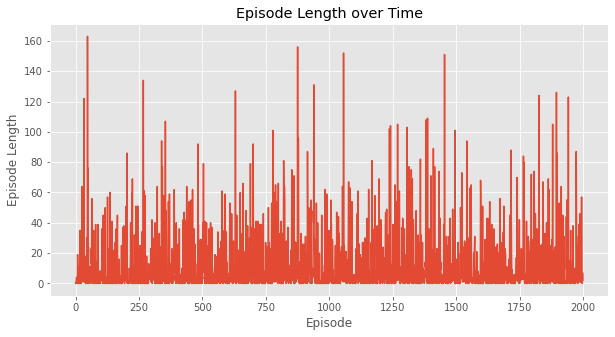

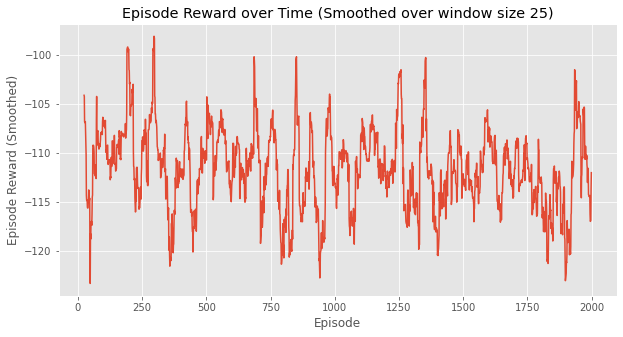

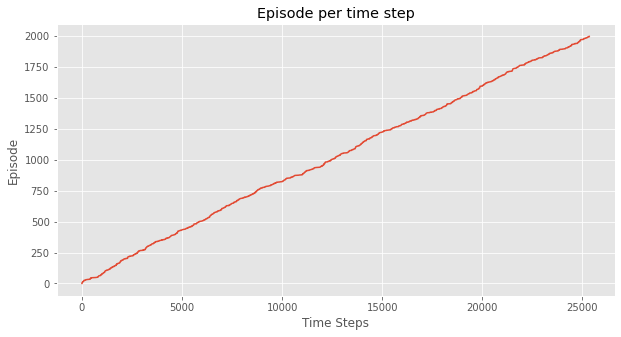

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [17]:
plot_episode_stats(stats, smoothing_window=25)